# Web Scraping Weather Data

In [19]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime


#Selects the date range for the web scraping, currently set to 2022 full year
start_date = datetime.datetime(2022, 1, 1)
today_date = datetime.datetime(2022, 12, 31)
# today_date = datetime.datetime.today()


# Generate a list of dates between the start and end dates
date_range = [start_date + datetime.timedelta(days=x) for x in range((today_date - start_date).days + 1)]

# Format the dates as strings delimited by hyphens for our link
date_range_hyphen = [date.strftime('%Y-%m-%d') for date in date_range]

for date in date_range_hyphen:
    # Specify the URL and use requests to get the HTML content
    url = f'https://www.wunderground.com/dashboard/pws/KNYJACKS2/table/{today_date}/{date}/daily'
    response = requests.get(url)
    html_content = response.content

    # Parse the HTML content using Beautiful Soup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the last table on the page and extract the data into a list of lists
    print(date)
    table = soup.find_all('table')[-1]
    rows = table.find_all('tr')
    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        data.append(cols)
    data[0] = ['Time', 'Temperature', 'Dew_Point', 'Humidity', 'Wind', 'Speed', 'Gust', 'Pressure', 'Precip_Rate', 'Precip_Accum', 'UV', 'Solar']

    # Convert the list of lists into a pandas dataframe
    # Print statements just show where data may have to be imputed, and also slow the program down so it doesn't outpace my internet
    try:
        df = pd.DataFrame(data[2:], columns=data[0])
    except:
        print(date)
    df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p')
    df['hour'] = df['Time'].dt.hour
    try:
        df.drop('Wind', axis = 1, inplace = True)
    except:
        print(date, 'wind problem')

    #Tries to change datatypes to numerical data, print statements show where data will need to be imputed later
    for col in df:
        if col == 'UV':
            df[col] = pd.to_numeric(df[col])
        elif df[col].dtypes == 'object':
            df[col] = df[col].map(lambda x: x.split()[0])
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                print(date, col)
    df_hourly = df.groupby(df.hour).mean()
    df_hourly['date'] = date
    df_hourly.reset_index(inplace=True)

    #Inits our weather dataframe the first pass through, and concats grouped data to it each time after, reusing as much as possible to use less ram
    if date == str(start_date.date()):
        dfw = df_hourly
    else:
        dfw = pd.concat([dfw,df_hourly], ignore_index=True)

2022-01-01
2022-01-02
2022-01-03
2022-01-04
2022-01-05
2022-01-06
2022-01-07
2022-01-08
2022-01-09
2022-01-10
2022-01-10 Gust
2022-01-11
2022-01-12
2022-01-12 Gust
2022-01-13
2022-01-14
2022-01-15
2022-01-16
2022-01-16 Temperature
2022-01-16 Dew_Point
2022-01-16 Humidity
2022-01-16 Speed
2022-01-16 Gust
2022-01-16 Solar
2022-01-17
2022-01-18
2022-01-19
2022-01-20
2022-01-21
2022-01-22
2022-01-23
2022-01-24
2022-01-25
2022-01-25 Gust
2022-01-26
2022-01-27
2022-01-28
2022-01-28 Gust
2022-01-29
2022-01-30
2022-01-30 Gust
2022-01-31
2022-01-31 Gust
2022-02-01
2022-02-01 Gust
2022-02-02
2022-02-03
2022-02-04
2022-02-05
2022-02-06
2022-02-07
2022-02-08
2022-02-09
2022-02-09 Gust
2022-02-10
2022-02-11
2022-02-12
2022-02-13
2022-02-14
2022-02-15
2022-02-16
2022-02-17
2022-02-18
2022-02-19
2022-02-20
2022-02-21
2022-02-22
2022-02-23
2022-02-24
2022-02-25
2022-02-26
2022-02-26 Gust
2022-02-27
2022-02-28
2022-03-01
2022-03-02
2022-03-03
2022-03-04
2022-03-04 Gust
2022-03-05
2022-03-06
2022-03-07


Cleaning the Data

In [89]:
dfw['Gust'].fillna(0, inplace=True)


In [34]:
#Changes datatype for merge
dfw['date'] = pd.to_datetime(dfw['date'])

In [31]:
dfw.date.value_counts()

2022-01-01    24
2022-09-07    24
2022-09-05    24
2022-09-04    24
2022-09-03    24
              ..
2022-03-13    23
2022-11-27    21
2022-06-01    17
2022-09-21    12
2022-06-02    12
Name: date, Length: 363, dtype: int64

## Getting Holidays via API

In [65]:
import requests
url = 'https://holidayapi.com/v1/holidays'
params = {
    'country':'US-NY',
    'year':'2022',
    'pretty': True,
    'key' : '734138b2-a9b0-4476-8dca-9edaf8116472'
}

response = requests.get(url, params=params)
hols = response.json()
hols = hols['holidays']

dfh = pd.json_normalize(hols)

display(dfh)

,name,date,observed,public,country,uuid,weekday.date.name,weekday.date.numeric,weekday.observed.name,weekday.observed.numeric
0,New Year's Day,2022-01-01,2021-12-31,True,US-NY,82f78b8a-019e-479e-a19f-99040275f9bf,Saturday,6,Friday,5
1,Seventh Day of Kwanzaa,2022-01-01,2022-01-01,False,US-NY,0e766ff3-0d31-40e1-85e1-49ed61ab006d,Saturday,6,Saturday,6
2,Epiphany,2022-01-06,2022-01-06,False,US-NY,61d8d9ba-8ce1-4e64-9b1a-f40d30f74a57,Thursday,4,Thursday,4
3,Orthodox Christmas Eve,2022-01-06,2022-01-06,False,US-NY,bc893ac4-be85-4af6-abad-687e923bbcec,Thursday,4,Thursday,4
4,Orthodox Christmas Day,2022-01-07,2022-01-07,False,US-NY,8ed029b2-c39d-46aa-b15a-4c67540380e4,Friday,5,Friday,5
...,...,...,...,...,...,...,...,...,...,...
142,Third Day of Kwanzaa,2022-12-28,2022-12-28,False,US-NY,121999c4-4966-4895-9f54-445ff432bb8b,Wednesday,3,Wednesday,3
143,Fourth Day of Kwanzaa,2022-12-29,2022-12-29,False,US-NY,40f2731d-ecee-4989-98b7-03cfb47b284a,Thursday,4,Thursday,4
144,Fifth Day of Kwanzaa,2022-12-30,2022-12-30,False,US-NY,07a0dad3-0a86-43f3-b0cf-43b74ce9f0fa,Friday,5,Friday,5
145,New Year's Eve,2022-12-31,2022-12-31,False,US-NY,6a153f07-0520-45be-83cd-ed6b6d743df0,Saturday,6,Saturday,6


Cleaning the data

In [66]:
dfh['weekday.date.numeric'] = dfh['weekday.date.numeric'].map(lambda x: int(x)-1)
dfh['weekday.observed.numeric'] = dfh['weekday.observed.numeric'].map(lambda x: int(x)-1)



,date,public,weekday.observed.name,weekday.observed.numeric
0,2021-12-31,True,Friday,4
1,2022-01-01,False,Saturday,5
2,2022-01-06,False,Thursday,3
3,2022-01-06,False,Thursday,3
4,2022-01-07,False,Friday,4
...,...,...,...,...
142,2022-12-28,False,Wednesday,2
143,2022-12-29,False,Thursday,3
144,2022-12-30,False,Friday,4
145,2022-12-31,False,Saturday,5


## Reading in Taxi Data

In [5]:
#List of months to iterate through the files
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11','12']

In [16]:
#Creates loop to read in and concat 
i=1
for month in months:                   
    df = pd.read_parquet(f'yellow_tripdata_{year}-{month}.parquet', engine='pyarrow')

    df['date'] = pd.to_datetime(df['tpep_pickup_datetime'].dt.date)
    df['hour'] = df['tpep_pickup_datetime'].dt.hour

    df['Trip_Length'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    if month != months[-1]:
        start = pd.to_datetime(f'{year}-{month}-01')
        end = pd.to_datetime(f'{year}-{months[i]}-01')
        df = df[(df['date'] >= start) & (df['date'] < end)]
        i +=1
    else:
        df = df[(df['date'] >= pd.to_datetime(f'{year}-{month}-01')) & (df['date'] < pd.to_datetime(f'2023-01-01'))]
    df = df.groupby(['date', 'hour']).agg({'passenger_count':['sum', 'count'], 'trip_distance':['sum', 'mean'], 'total_amount':'sum', 'Trip_Length':['sum', 'mean']})
    df.reset_index(inplace=True)
    if month == '01':
        dfg = df
    else:
        dfg = pd.concat([dfg,df], ignore_index = True)

In [23]:
# Resets column names for clarity
dfg.columns = ['date', 'hour', 'Total Passengers', 'Amount of Trips', 'Total Distance', 'Average Distance','Total Fares', 'Total Time', 'Averge Time']
dfg['day_of_week'] = dfg['date'].dt.dayofweek


### Merging the data

In [36]:
#Inner Join the two data sets
dfgw = dfg.set_index(['date', 'hour']).join(dfw.set_index(['date', 'hour']), how='inner')

In [80]:
#Left join with the holiday data
dfgwh = dfgw.set_index('date').join(dfh.set_index('observed'), how='left')

Send to CSV for EDA

In [38]:
dfg.to_csv('Cleaned_Taxi')
dfw.to_csv('Cleaned_Weather')
dfh.to_csv('Cleaned_Holidays')
dfgwh.to_csv('Cleaned_Merge.csv')

In [67]:
# import pandas as pd
# dfgwh = pd.read_csv('Cleaned_Data.csv')

## ML in progress

In [24]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn import linear_model
import statistics
import matplotlib.pyplot as plt
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

Null Checking

In [102]:
dfgwh.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8652 entries, 2022-01-01 to 2022-12-31
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hour              8652 non-null   int64  
 1   Total Passengers  8652 non-null   float64
 2   Amount of Trips   8652 non-null   int64  
 3   Total Distance    8652 non-null   float64
 4   Average Distance  8652 non-null   float64
 5   Total Fares       8652 non-null   float64
 6   Temperature       8652 non-null   float64
 7   Dew_Point         8652 non-null   float64
 8   Humidity          8652 non-null   float64
 9   Speed             8652 non-null   float64
 10  Gust              8652 non-null   float64
 11  Pressure          8652 non-null   float64
 12  Precip_Rate       8652 non-null   float64
 13  Precip_Accum      8652 non-null   float64
 14  UV                8652 non-null   float64
 15  Solar             8652 non-null   float64
 16  day_of_week       8652 n

In [94]:
nulls = dfgwh[dfgwh.isna().any(axis=1)]
display(nulls)

,hour,Total Passengers,Amount of Trips,Total Distance,Average Distance,Total Fares,Total Time,Averge Time,Temperature,Dew_Point,Humidity,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,day_of_week,public


Cleaning for ML

In [57]:
#Declare functions for apply statements
def publicclean(x):
    if pd.isna(x):
        return 0
    elif x == False:
        return 1
    elif x == True:
        return 2
    else:
        print(x, ' Did not get changed :(')

In [86]:
#Cleaning Holiday Nulls
dfgwh['public'] = dfgwh['public'].apply(publicclean)
dfgwh.drop(['name', 'country', 'uuid', 'weekday.date.name', 'weekday.date.numeric', 'date'], axis = 1, inplace=True)
dfgwh.rename(columns = {'observed': 'date'})
dfgwh.drop(['weekday.observed.name', 'weekday.observed.numeric'], axis=1, inplace=True)


In [93]:
dfgwh.dropna(axis=0, inplace=True)

XGboost attempt

In [95]:
import xgboost as xgb

In [98]:
dfgwh.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8652 entries, 2022-01-01 to 2022-12-31
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hour              8652 non-null   int64  
 1   Total Passengers  8652 non-null   float64
 2   Amount of Trips   8652 non-null   int64  
 3   Total Distance    8652 non-null   float64
 4   Average Distance  8652 non-null   float64
 5   Total Fares       8652 non-null   float64
 6   Temperature       8652 non-null   float64
 7   Dew_Point         8652 non-null   float64
 8   Humidity          8652 non-null   float64
 9   Speed             8652 non-null   float64
 10  Gust              8652 non-null   float64
 11  Pressure          8652 non-null   float64
 12  Precip_Rate       8652 non-null   float64
 13  Precip_Accum      8652 non-null   float64
 14  UV                8652 non-null   float64
 15  Solar             8652 non-null   float64
 16  day_of_week       8652 n

In [97]:
dfgwh.drop(['Total Time', 'Averge Time'], axis='columns', inplace = True)

688.5276687232006 940.6013104836129


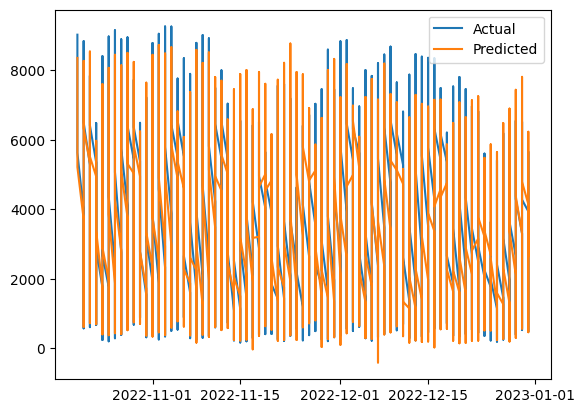

0.857564954993786


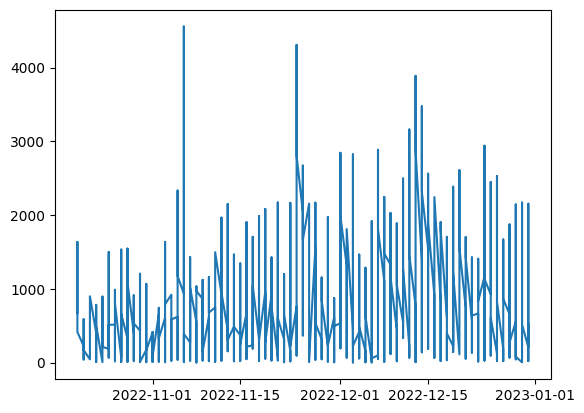

In [101]:
X = dfgwh.drop(['Amount of Trips', 'Total Fares', 'Total Passengers', 'Total Distance'], axis = 1)
y = dfgwh['Amount of Trips']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, shuffle=False)

xmodel = xgb.XGBRegressor()

xmodel.fit(Xtrain, ytrain)

preds = xmodel.predict(Xtest)

mae = mean_absolute_error(ytest, preds)
rmse = np.sqrt(mean_squared_error(ytest, preds))

print(mae, rmse)

plt.plot(Xtest.index, ytest, label = 'Actual')
plt.plot(Xtest.index, preds, label = 'Predicted')
plt.legend()
plt.show()
print(xmodel.score(Xtest, ytest))

plt.plot(Xtest.index, np.abs(ytest - preds))
plt.show()